In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.models import Model
import random as rn
import pathlib
import random
import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from keras.models import load_model


In [2]:
%%time
path_train = r"./datasets/fruits/training"
path_val = r"./datasets/fruits/validation"
datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    brightness_range=[1,0.4],
    channel_shift_range=0.1,
    horizontal_flip=True
)
train_generator=datagen.flow_from_directory(directory=path_train, color_mode = 'rgb', 
                                            class_mode="categorical",
                                            shuffle=True,
                                            target_size=(256,256), 
                                            batch_size=32)
validation_generator=datagen.flow_from_directory(directory=path_val, color_mode = 'rgb', 
                                            class_mode="categorical",
                                            shuffle=True,
                                            target_size=(256,256), 
                                            batch_size=32)

Found 3345 images belonging to 2 classes.
Found 1283 images belonging to 2 classes.
Wall time: 162 ms


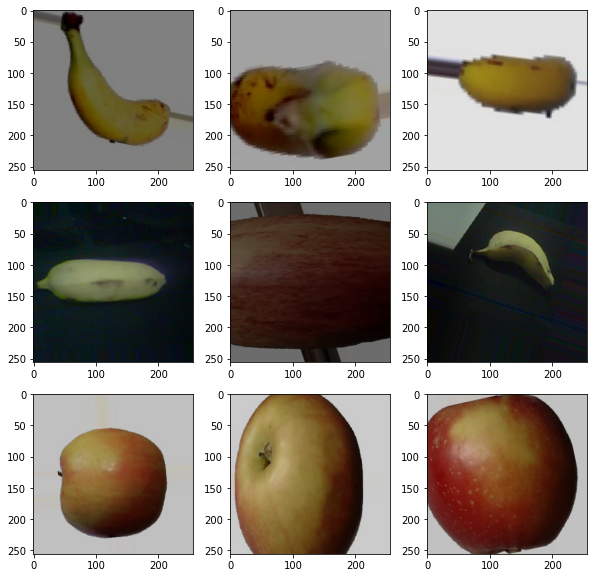

In [3]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):    
    img, label = train_generator.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow((img[0] * 255).astype(np.uint8))
plt.show()

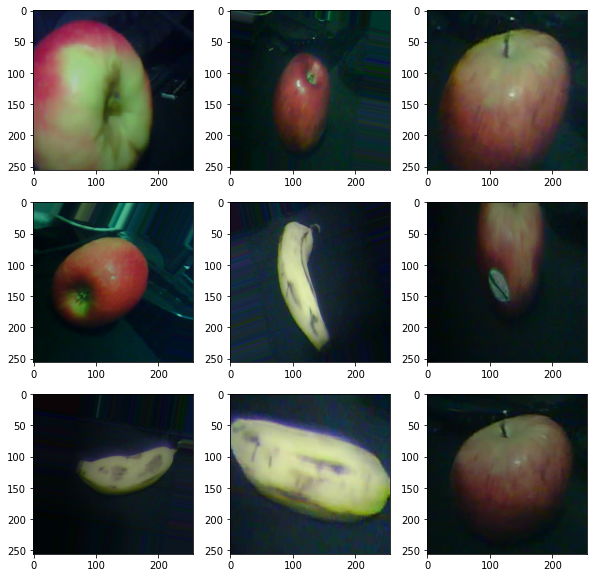

In [4]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):    
    img, label = validation_generator.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow((img[0] * 255).astype(np.uint8))
plt.show()

In [5]:
base_model = VGG16(include_top=False, 
                   weights='imagenet', 
                   input_shape=(256,256,3), 
                   pooling=None)

for layer in base_model.layers:
    layer.trainable = False

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [7]:
cust_model = Sequential()
cust_model.add(base_model)
cust_model.add(Conv2D(filters=32,
                      kernel_size=(3,3),
                      strides=(1,1),
                      activation='relu',
                      kernel_initializer=tf.keras.initializers.he_normal(seed=0),
                      name='Cust_Conv1'))
cust_model.add(MaxPool2D(pool_size=(2,2),
                         strides=(2,2),
                         name='Cust_Pool1'))
cust_model.add(Flatten())
cust_model.add(Dense(units=128,
                     activation='relu',
                     kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
                     name='Cust_FC1'))
cust_model.add(Dense(units=64,
                     activation='relu',
                     kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),
                     name='Cust_FC2'))
cust_model.add(Dense(units=2,
                     activation='sigmoid',
                     kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),
                     name='Output'))
print(cust_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
Cust_Conv1 (Conv2D)          (None, 6, 6, 32)          147488    
_________________________________________________________________
Cust_Pool1 (MaxPooling2D)    (None, 3, 3, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
Cust_FC1 (Dense)             (None, 128)               36992     
_________________________________________________________________
Cust_FC2 (Dense)             (None, 64)                8256      
_________________________________________________________________
Output (Dense)               (None, 2)                 1

In [8]:
cust_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',                 
                   metrics=['accuracy'])

In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

104
40


In [10]:
history = cust_model.fit(
    train_generator,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_data = validation_generator, 
    validation_steps = STEP_SIZE_VALID,
    epochs = 2)


Epoch 1/2
104/104 [==============================] - 85s 692ms/step - loss: 0.2292 - accuracy: 0.9116 - val_loss: 0.3892 - val_accuracy: 0.8203
Epoch 2/2
104/104 [==============================] - 66s 634ms/step - loss: 0.0634 - accuracy: 0.9752 - val_loss: 0.4747 - val_accuracy: 0.7914


In [11]:
path_test = r"./datasets/fruits/tests"
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(directory=path_test, color_mode = 'rgb', 
                                            class_mode="categorical",
                                            shuffle=False,
                                            target_size=(256,256), 
                                            batch_size=1,
                                            seed=42)

Found 465 images belonging to 2 classes.


In [12]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
STEP_SIZE_TEST

465

In [13]:
cust_model.evaluate(test_generator,
steps=STEP_SIZE_TEST)

465/465 [==============================] - 5s 10ms/step - loss: 0.3252 - accuracy: 0.8495


[0.3251652419567108, 0.8494623899459839]

In [14]:
cust_model.save("model_apple_banana.h5", save_format="h5")

In [15]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

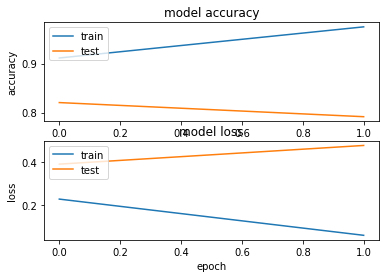

In [16]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

{'apple': 0, 'banana': 1}
24576/10355 [=======================================================================] - 0s 1us/step
downloaded C:\Users\Murilo\.keras\datasets\a9684097-4ebd-41a4-9607-cc18751ff6f3
prediction: [[1.0504111e-25 1.0000000e+00]]
This image most likely belongs to banana with a 100.000 percent confidence.


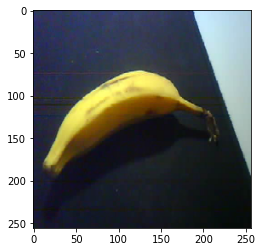

In [31]:
import uuid
import keras

print(validation_generator.class_indices)
inv_classes = validation_generator.class_indices
classes = {v: k for k, v in inv_classes.items()}

capture_url = "http://192.168.0.243/capture"
capture_path = tf.keras.utils.get_file(str(uuid.uuid4()), origin=capture_url)
# capture_path = "./datasets/fruits-360-original-size/Test/cucumber_1/r0_3.jpg" 

print(f'downloaded {capture_path}')

img = keras.preprocessing.image.load_img(
    capture_path, target_size=(256, 256)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = cust_model.predict(img_array, verbose=0)

print(f'prediction: {predictions}')

score = predictions[0]

plt.imshow(img)

threshold = 0.3
if (1 - abs(np.max(score)) >= threshold):
    print('This image could not be classified')
else:
    print(
        "This image most likely belongs to {} with a {:.3f} percent confidence."
        .format(classes[np.argmax(score)], 100 * float(np.max(score)))
    )